# **Prompt Engineering**

Prompt examples :

https://platform.openai.com/docs/examples

In [ ]:
pip install openai


In [ ]:
import os
from openai import OpenAI

# API 키 설정
os.environ['OPENAI_API_KEY'] = 'OPENAI_API_KEY'


In [ ]:
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

def chatGPT(msgs, temp=0.8, maxtoken=4096):
    response = client.chat.completions.create(
        model='gpt-3.5-turbo-16k',
        messages=msgs,
        temperature=temp,
        max_tokens=maxtoken
    )
    return response



In [ ]:
msg = [
    {"role":"system", "content":"You will be provided with text, and your task is to translate it into emojis. Do not use any regular text. Do your best with emojis only."},
    {"role":"user", "content":"안녕 반가워"}
    ]

response = chatGPT(msg)
print(response.choices[0].message.content)


In [ ]:
msg = [
    {"role":"system", "content":"You will be provided with a sentence in English, and your task is to translate it into French."},
    {"role":"user", "content":"안녕 반가워"}
    ]

response = chatGPT(msg)
print(response.choices[0].message.content)


# **Prompt Engineering Guide**

## **https://www.promptingguide.ai/techniques/cot**

In [ ]:
def gpt_chat(role, message):
    """GPT와 대화하는 함수"""
    messages=[
      {"role": "system", "content": f"You are a {role}. Please respond thoughtfully.Have to response korean"},
      {"role": "user", "content": message},
    ]
    response = chatGPT(messages)
    return response.choices[0].message.content

def collaborative_discussion(topic, rounds=3):
    """GPT 모델 간 협업적 논의 진행"""
    discussion_log = []

    for round_num in range(rounds):
        print(f"\n--- Round {round_num + 1} ---\n")

        # 사고자의 의견
        thinker_prompt = f"The topic is: '{topic}'. As a thinker, propose an idea or solution."
        thinker_response = gpt_chat("Thinker", thinker_prompt)
        print(f"[Thinker]: {thinker_response}")
        print('\n\n')

        # 비평가의 피드백
        critic_prompt = f"As a critic, evaluate the following idea critically: '{thinker_response}'"
        critic_response = gpt_chat("Critic", critic_prompt)
        print(f"[Critic]: {critic_response}")
        print('\n\n')

        # 조정자의 통합
        moderator_prompt = (
            f"As a moderator, reconcile the following arguments:\n"
            f"Thinker's idea: '{thinker_response}'\n"
            f"Critic's feedback: '{critic_response}'\n"
            "Provide a balanced conclusion or revised idea."
        )
        moderator_response = gpt_chat("Moderator", moderator_prompt)
        print(f"[Moderator]: {moderator_response}")
        print('\n\n')

        # 로그 저장
        discussion_log.append({
            "Round": round_num + 1,
            "Thinker": thinker_response,
            "Critic": critic_response,
            "Moderator": moderator_response
        })

    # 최종 결론
    final_prompt = (
        "Based on the following discussion log, provide a final conclusion or actionable outcome:\n" +
        "\n".join(
            f"Round {log['Round']} - Thinker: {log['Thinker']} | Critic: {log['Critic']} | Moderator: {log['Moderator']}"
            for log in discussion_log
        )
    )
    final_conclusion = gpt_chat("Finalizer", final_prompt)
    print(f"\n[Final Conclusion]: {final_conclusion}")
    print('\n\n')
    return discussion_log, final_conclusion

# 논의 주제
topic = "한양대학교 인근 맛집을 찾는 방법?"

# 논의 실행
discussion_log, conclusion = collaborative_discussion(topic)


# **RAG(Retrieve Augmented Generation)**

https://yozm.wishket.com/magazine/detail/2828/

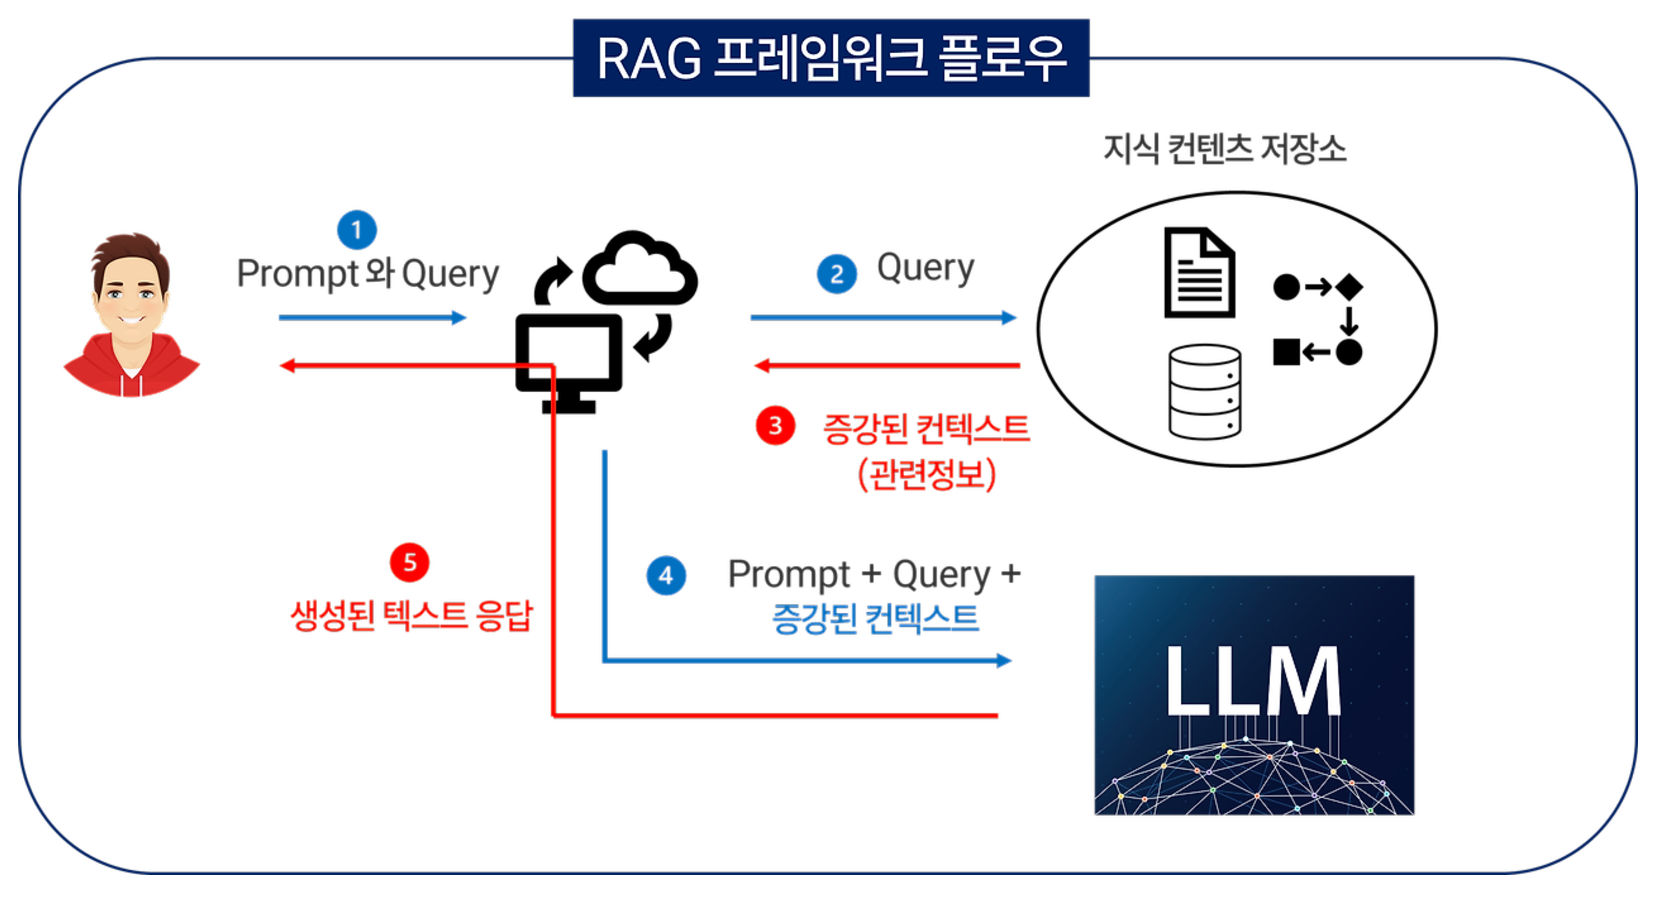

In [ ]:
# 설치
!pip install requests beautifulsoup4 openai

In [ ]:

import requests
from bs4 import BeautifulSoup
import openai


def google_search(query, num_results=5):
    """
    Google 검색을 통해 검색 결과를 가져옵니다.
    """
    # 검색 URL 생성
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36"
    }
    search_url = f"https://www.google.com/search?q={query.replace(' ', '+')}&hl=en"

    # HTTP 요청
    response = requests.get(search_url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"Google Search failed with status code {response.status_code}")

    # HTML 파싱
    soup = BeautifulSoup(response.text, "html.parser")
    search_results = []
    for g in soup.select(".tF2Cxc")[:num_results]:  # ".tF2Cxc"는 검색 결과의 CSS 클래스
        title = g.select_one(".DKV0Md").text if g.select_one(".DKV0Md") else "No Title"
        snippet = g.select_one(".VwiC3b").text if g.select_one(".VwiC3b") else "No Snippet"
        link = g.select_one(".yuRUbf a")["href"] if g.select_one(".yuRUbf a") else "No Link"
        search_results.append(f"Title: {title}\nSnippet: {snippet}\nLink: {link}")
    return search_results

def gpt_rag(query, search_results):
    """
    검색 결과를 기반으로 GPT 응답을 생성합니다.
    """
    # 검색 결과를 하나의 문자열로 결합
    context = "\n\n".join(search_results)

    # GPT에게 전달할 프롬프트 생성
    prompt = (
        f"The following are search results from Google for the query: '{query}'.\n\n"
        f"{context}\n\n"
        "Using the information above, provide a detailed and concise answer to the query."
    )

    # GPT 호출
    messages=[
        {"role": "system", "content": "You are a helpful assistant that generates answers based on provided search results."},
        {"role": "user", "content": prompt},
    ]
    response = chatGPT(messages)
    return response.choices[0].message.content

# 메인 실행 코드
if __name__ == "__main__":
    # 사용자 질문 입력
    query = input("Enter your question: ")

    print("\n[Step 1] Performing Google Search...\n")
    search_results = google_search(query, num_results=5)

    print("Search Results:")
    for i, result in enumerate(search_results, 1):
        print(f"{i}. {result}\n")

    print("\n[Step 2] Generating Answer with GPT...\n")
    answer = gpt_rag(query, search_results)
    print("Answer:")
    print(answer)